In [5]:
import sys
import os
import json
import statistics

src_directory = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.append(src_directory)

In [6]:

def load_test_contracts(test_data_dir):
    text_dir = os.path.join(test_data_dir, "text")

    test_contracts = {}

    for sub_folder in os.listdir(text_dir):
        text_sub_folder = os.path.join(text_dir, sub_folder)
        
        if os.path.isdir(text_sub_folder):
            contracts = []
            for text_file in os.listdir(text_sub_folder):
                if text_file.endswith(".txt"):
                    text_path = os.path.join(text_sub_folder, text_file)
                    
                    if os.path.exists(text_path):
                       
                        with open(text_path, 'r') as tf:
                            text_content = tf.read()
                        
                        contracts.append({
                            "id": text_file.replace("txt", "json"),
                            "description": text_content
                        })
            
            if contracts:
                test_contracts[sub_folder] = contracts

    return test_contracts



def compute_summary_stats(test_data_dir, generated_cdm_parent_folder, generated_cdm_folder):
    
    test_contracts = load_test_contracts(test_data_dir)

    scores, scores_rag = {}, {}
    all_scores, all_scores_rag = [], []

    for contract_type, contracts in test_contracts.items():

        if contract_type != "InterestRate":
            continue

        scores[contract_type], scores_rag[contract_type] = [], []
        
        for contract in contracts:
            for mode, store in [("without_rag", scores[contract_type]), ("with_rag", scores_rag[contract_type])]:
                path = os.path.join(generated_cdm_parent_folder, generated_cdm_folder, mode, contract_type, contract['id'])
                
                if os.path.exists(path):
                    with open(path) as f:
                        curr_scores = json.load(f)['score']
                        store.append(curr_scores)
                        if mode == "without_rag":
                            all_scores.append(curr_scores)
                        else:
                            all_scores_rag.append(curr_scores)
                else:
                    print(f"!!! ({mode.upper()}) eval results do not exist: {path}")

    # Compute statistics for each contract type
    def compute_stats(data):
        return {
            "min": min(data) if data else None,
            "max": max(data) if data else None,
            "mean": sum(data) / len(data) if data else None,
            "median": statistics.median(data) if data else None,
            "sd": statistics.stdev(data) if len(data) > 1 else 0  # Avoid error when len(data) < 2
        } if data else {}

    contract_type_stats = {key: compute_stats(values) for key, values in scores.items()}
    contract_type_stats_rag = {key: compute_stats(values) for key, values in scores_rag.items()}

    # Compute overall statistics for all contract types combined
    # contract_type_stats["AllTypesCombined"] = compute_stats(all_scores)
    # contract_type_stats_rag["AllTypesCombined"] = compute_stats(all_scores_rag)

    return contract_type_stats, contract_type_stats_rag


In [7]:
test_data_dir = "../../../Data_from_BofA/FIIR_Confirms_32"
generated_cdm_parent_folder = "../../../Data_from_BofA/FIIR_Confirms_32/evaluation_results_cdm"
generated_cdm_folder = "Meta-Llama-3.1-8B-Instruct"

summary_stats, summary_stats_rag = compute_summary_stats(test_data_dir, generated_cdm_parent_folder, generated_cdm_folder)

print(summary_stats)
print(summary_stats_rag)

{'InterestRate': {'min': 30.156815440289503, 'max': 100.0, 'mean': 79.42819562190208, 'median': 86.3776691535889, 'sd': 20.918699974327488}}
{'InterestRate': {'min': 26.470588235294116, 'max': 100.0, 'mean': 79.95605536114527, 'median': 85.25247758376594, 'sd': 17.97781117342443}}


['InterestRate']


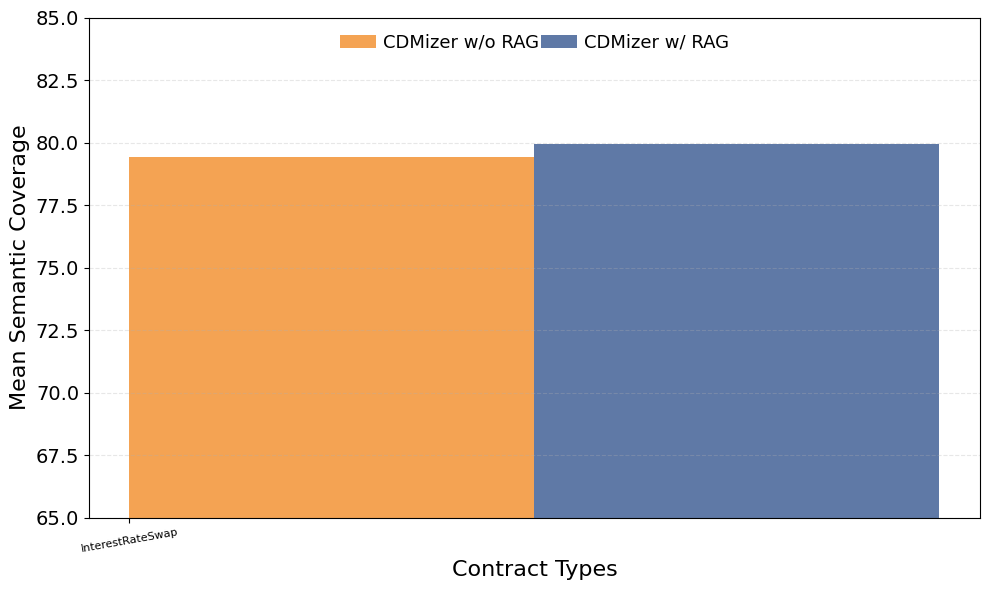

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Keep your original colors
# colors = ["#E15759", "#76B7B2", "#F28E2B", "#4E79A7"]
colors = ["#E46869", "#96D58A", "#F39940", "#4E6B9C"]


contract_types = list(summary_stats.keys())

display_labels = {
    "InterestRate": "InterestRateSwap",
    "Commodity": "CommodityOption",
    "ForeignExchange": "ForeignExchangeDerivatives"
}

print(contract_types)

xtick_labels = [display_labels.get(c, c) for c in contract_types]

# Extract means
means_summary = [summary_stats[c]['mean'] for c in contract_types]
means_summary_rag = [summary_stats_rag[c]['mean'] for c in contract_types]

# Extract standard deviations (SD)
sd_summary = [summary_stats[c]['sd'] for c in contract_types]
sd_summary_rag = [summary_stats_rag[c]['sd'] for c in contract_types]

x = np.arange(len(contract_types))
width = 0.18

fig, ax = plt.subplots(figsize=(10, 6))

# Plot bars with SD error bars (matching colors, subtle caps)
# ax.bar(x - 1.5*width, means_summary_2, width, yerr=sd_summary_2, capsize=2, error_kw=dict(lw=0.6, capthick=0.5), label="Baseline w/o RAG", color=colors[0], alpha=0.9)
# ax.bar(x - 0.5*width, means_summary_rag_2, width, yerr=sd_summary_rag_2, capsize=2, error_kw=dict(lw=0.6, capthick=0.5), label="Baseline w/ RAG", color=colors[1], alpha=0.9)
# ax.bar(x + 0.5*width, means_summary, width, yerr=sd_summary, capsize=2, error_kw=dict(lw=0.6, capthick=0.6), label="CDMizer w/o RAG", color=colors[2], alpha=0.9)
# ax.bar(x + 1.5*width, means_summary_rag, width, yerr=sd_summary_rag, capsize=2, error_kw=dict(lw=0.6, capthick=0.5), label="CDMizer w/ RAG", color=colors[3], alpha=0.9)


ax.bar(x + 0.5*width, means_summary, width, label="CDMizer w/o RAG", color=colors[2], alpha=0.9)
ax.bar(x + 1.5*width, means_summary_rag, width, label="CDMizer w/ RAG", color=colors[3], alpha=0.9)



# Set x-axis labels
ax.set_xticks(x)
ax.set_xticklabels(xtick_labels, rotation=10, fontsize=8)

# Labels & Formatting (unchanged from your original)
ax.set_ylabel("Mean Semantic Coverage", fontsize=16)
ax.set_xlabel("Contract Types", fontsize=16)
ax.set_ylim(65, 85)
ax.tick_params(axis="y", labelsize=14)

# Legend (exact same position & format as yours)
ax.legend(title="", loc="upper center", bbox_to_anchor=(0.5, 1.0), ncol=4, fontsize=13, handletextpad=0.4, columnspacing=0.1, frameon=False)

# Light gridlines for readability
ax.grid(axis="y", linestyle="--", alpha=0.3)

# Keep layout tight for a clean look
plt.tight_layout()
plt.show()
